# How to: build an N-body self-consistent model from a Sersic law
This short tutorial explains how to use the (old-version) package *pygme* to build a self-consistent model with particles.
The basis for this can be found in papers written in the 90's, namely:
* Monnet et al. 1992
* Emsellem et al. 1994

See Emsellem et al. 1999 on the modelling of NGC3115 for a more detailed example.

# 0 - Importing the modules

In [14]:
# importing modules
import numpy as np
# pygme itself
import pygme
# the fitting for N 2Dimensional Gaussians
from pygme.fitting import fitn2dgauss
import matplotlib.pyplot as plt

You can ignore the warnings above. This comes from an import of lmfit, which is by default not installed.
Note: all the pygme code has been made compatible with python3 using *2to3*. A new version of pygme is being developed which is more pythonic and more robust, but this is written entirely from scratch.

# 1 - Setting up the Sersic Law
Now we are going to use the Sersic module to set up a luminosity profile

In [15]:
# We import the module
from pygme.astroprofiles import sersic
# We first set up a sampling in radius (in parsec)
# From let's say 1 pc to about 10000 pc
rsamp = np.logspace(0.,4.,1001)
# now we get the profile itself - Re = 1.5kpc, rsamp goes to 6000pc, hence 4 Re
myprofile = sersic.SersicProfile(n=2, Ie=1.0, Re=1500.0, rsamp=rsamp)

/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/astroprofiles/data/Abel_param.dat


Let's **plot the profile** to check that everything is fine

Text(0, 0.5, 'Sersic law - projected profile [log10]')

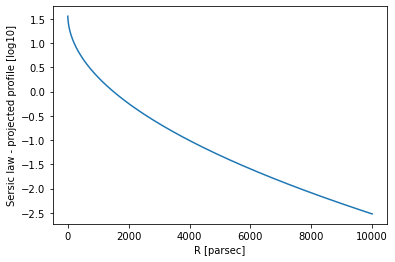

In [16]:
%matplotlib inline
plt.plot(myprofile.r, np.log10(myprofile.rhop))
plt.xlabel("R [parsec]")
plt.ylabel("Sersic law - projected profile [log10]")

## 2 - Fitting the profile
Now it's time to fit this with a **Multi-Gaussian Expansion (MGE) model**.

Here it goes:

In [17]:
# Defining the maximum number of gaussians to approximate the profile.
nGauss = 15
# Importing the fitting routine
from pygme.fitting.fitn1dgauss import multi_1dgauss_mpfit
# Doing the fit
bestparSersic, mpfit_output, fitSersic = multi_1dgauss_mpfit(myprofile.r, myprofile.rhop, ngauss=nGauss)

------ Starting the minimisation -------
Chi2 =  0.03401247668358233
Chi2 =  0.005113104466323175
Chi2 =  0.0008962695648104279
Chi2 =  0.000534281586367988
Chi2 =  0.00030591010615158107
Chi2 =  0.00026109023808632367
Chi2 =  0.00022064407705555983
Chi2 =  0.00019257649192323112
Chi2 =  0.0001730077804230775
Chi2 =  0.00015918000536150532
Chi2 =  0.00014926438757026603
Chi2 =  0.0001420507229596635
Chi2 =  0.0001367398036367624
Chi2 =  0.00013279382559093072
Chi2 =  0.0001298415280330887
Chi2 =  0.00012762114016004076
Chi2 =  0.000125944641023616
Chi2 =  0.0001246751492948273
Chi2 =  0.00012371176881514787
Chi2 =  0.00012297954618742914
Chi2 =  0.00012242234639077
Chi2 =  0.00012199796418625517
Chi2 =  0.00012167455670069685
Chi2 =  0.00012142799171282818
Chi2 =  0.00012123995263064202
Chi2 =  0.0001210965178384601
Chi2 =  0.00012098710859917158
Chi2 =  0.000120903625218257
Chi2 =  0.00012083991899065288
Chi2 =  0.0001207913117609147
Chi2 =  0.00012075422849600156
Chi2 =  0.0001207259

/home/fraison/anaconda3/lib/python3.6/site-packages/pygme/fitting/mpfit.py:2268: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


The **result** is only using 14 Gaussians as this is what the optimisation found (the routine felt it was enough to fit the profile properly). We can check the quality of that fit now to be on the safe side.

Text(0, 0.5, 'log($\\rho$)')

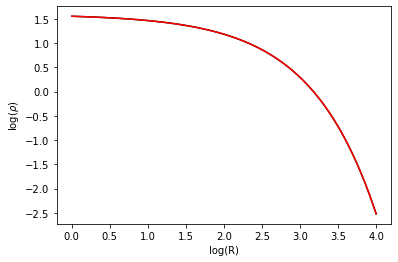

In [18]:
# Checking the quality of the fit by plotting in black the original profile and in red the fit
plt.clf()
plt.plot(np.log10(myprofile.r), np.log10(myprofile.rhop), 'k-')
plt.plot(np.log10(myprofile.r), np.log10(fitSersic), 'r-')
plt.xlabel('log(R)')
plt.ylabel(r'log($\rho$)')

Hard to see the difference, meaning that the fit is very good, from 0.1pc to 6000 pc!

Let's visualise the **residuals themselves** in %:

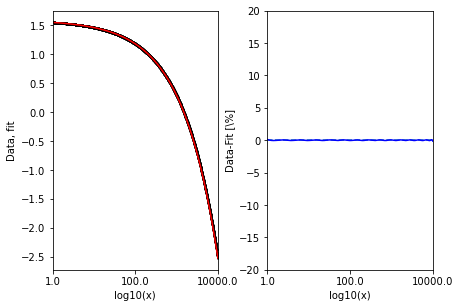

In [19]:
# Plotting the residuals in %
from pygme.fitting.examine_fit import plot_1dfit_residuals
plot_1dfit_residuals(myprofile.r, myprofile.rhop, fitSersic)

The residuals are much less than ~1% over the full range. Good.

# 3- Transforming the MGE fit into an N-body 3D model
It's now time to turn this into a bona fide N body model. 

We have obtained the best fit Multi Gaussian parameters for a 1D Sersic profile. This can easily be converted into a 2D profile. Imagine the 1D profile is just the cut along the major-axis. Then a 2D Sersic galaxy would just have the same profile along the minor-axis, just rescaled with the axis ratio. So it is easy to turn this into a 2D *projected* model, which has a certain axis ratio (b/a) and has a Sersic profile along its major-axis.

So let's use the parameters of that MGE best fit model to 1- Set up a 2D MGE model, 2- deproject the MGE model in 3D so to obtain an MGE model with 3D Gaussians, and then 2- use that 3D MGE model to generate an N-body, self-consistently.

The first Step is to arrange the fitted parameters into arrays which can be used to create the model. We usually go through the saving of an ascii file where all parameters will be written up. This is also practical if you wish to change something by hand later on.

In [20]:
# Number of Gaussian for the N body
ngaussModel = bestparSersic.shape[0]
# We add some zeros (0) to add 1- the axis ratio 2- position angle 
parModel = np.hstack((bestparSersic, np.ones((ngaussModel,2))))
# Units - let's put the galaxy at 20 Mpc, hence ~97pc / arcsec
pc_per_arcsec_10Mpc= 48.481368110 # pc/arcsec = Distance_Mpc * Pi / 0.648
kpc3_to_pc3= 1.e9
kpc_to_pc=1.e3

# First column is the amplitude. We can change it with some factor to make the total mass that we want
# factor_luminosity is set arbitrarily here so that later we get something reasonable for the luminosity
# of the galaxy. Hence you can change that in any way you wish (if you want larger or smaller galaxies)
factor_luminosity = 100.0 
parModel[:,0] *= factor_luminosity
# Transforming the sigmas (second column) into arcsec, as we did set up the radii in parsec initially
parModel[:,1] /= pc_per_arcsec_10Mpc
# Let's add some axis ratio - here let's decide it is b/a= 0.8 (ellipticity is 1-b/a = 0.2)
parModel[:,2] = 0.8


# We now create the MGE ascii file which will save the best fit parameters of the Model
# We only have "stars" but in principle we could add a model for the Dark Halo or the Gas

# THe parameters are:
#     NGauss = Number of Gaussians used for modelling [stars, gas, DM]
#     NPartGroup/NPartRealised = list of npart for groups specified, number of Particles per Group, and number of such particles "realised" 

# Import the module
from pygme.paramMGE import create_mge
# Do it - using 1 Million = 1000000 particles
# The programme creates an ascii file "Sersic_firstmodel_08.mge" with the parameters of the projected and deprojected Gaussians
# Since we provide 2D Gaussians (with an axis ratio), the programme will deproject these in 3D too.
nstars = 1000
create_mge(outfilename="Sersic_firstmodel_08.mge", Gauss2D=parModel, NGauss=(ngaussModel,0,0), 
           overwrite=True, Distance=20., NGroup=1, NDynGroup=1, NPartGroup=(nstars,0,0), 
           NRealisedPartGroup=(nstars,0,0))

WARNING with status 1 while Problem with Euler angles, will set the default = 0, 90, 0 = edge-on
Edge-on deprojection

Deprojected Model with inclination of 90.00
      #       Imax              Sigma       Qx        Qy
           Lsun/pc^2/arcsec     arcsec
3D-G  1    3.07850209e+03           0.02197   0.80000   0.80000
3D-G  2    1.66673897e+03           0.05605   0.80000   0.80000
3D-G  3    9.30767430e+02           0.13232   0.80000   0.80000
3D-G  4    5.23367750e+02           0.29288   0.80000   0.80000
3D-G  5    2.91428383e+02           0.61255   0.80000   0.80000
3D-G  6    1.57953358e+02           1.21719   0.80000   0.80000
3D-G  7    8.17970421e+01           2.30677   0.80000   0.80000
3D-G  8    3.96662734e+01           4.18175   0.80000   0.80000
3D-G  9    1.76303879e+01           7.26938   0.80000   0.80000
3D-G 10    7.02579442e+00          12.14858   0.80000   0.80000
3D-G 11    2.45791789e+00          19.59047   0.80000   0.80000
3D-G 12    7.39217331e-01          30

# 3- Use the model
We now have an ascii file with the right MGE parameters to use as a model.
Let's have a look at it.

In [21]:
# Let's read the model. The output will provide some details of what it is
myMGE = pygme.MGE("Sersic_firstmodel_08.mge")

The BetaEps vector (beta = FacBetaEps * Epsilon) is fixed to  
                    [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
WARNING with status 1 while Both 3D and 2D Gaussians were found: 
WARNING with status 1 while We thus used the 2D Gaussians as a prior for the deprojection at 90.00 degrees
Edge-on deprojection

Deprojected Model with inclination of 90.00
      #       Imax              Sigma       Qx        Qy
           Lsun/pc^2/arcsec     arcsec
3D-G  1    3.07862868e+03           0.02197   0.80000   0.80000
3D-G  2    1.66671750e+03           0.05605   0.80000   0.80000
3D-G  3    9.30790951e+02           0.13232   0.80000   0.80000
3D-G  4    5.23365196e+02           0.29288   0.80000   0.80000
3D-G  5    2.91430087e+02           0.61255   0.80000   0.80000
3D-G  6    1.57953205e+02           1.21719   0.80000   0.80000
3D-G  7    8.17972019e+01           2.30677   0.80000   0.80000
3D-G  8    3.96662201e+01           4.18175   0.80000   0.80000
3D-G  9 

In [22]:
# Let's now see some basic parameters
# Like: total Mass (in Msun)
print(myMGE.TMGEMass / 1.e9)

363632394049.29785


This means ~ 10^10 Msun. The use of the normalisation factor on the Luminosity is actually important (we used a factor of 100, which means that the initial model was only 10^8 Lsun).

**Important Note**: when initialising the model, the Mass to Light ratio M/L is always 1 for all Gaussians. Hence the model is ~10^10 Msun and ~10^10 Lsun too :-)

### Visualisation
We can also visualise the model in 2D (projected) or in 3D (deprojected)

In [13]:
# Let's now compute a few things like
# The circular velocity profile of this model
R = np.linspace(1, 100, 100) # in arcsec
Vc = myMGE.Vcirc(R=R)
plot(R, Vc, 'k-')
xlabel("R [arcsec]")
ylabel("V circular [km/s]")

NameError: name 'myMGE' is not defined

In [2]:
# This is the truncation radius (beyond = no particles)
maxR = 10000.0  # in parsec
# Making the N-body realisation
myMGE.realise_Nbody(mcut=maxR, TruncationMethod="Ellipsoid")

NameError: name 'myMGE' is not defined

# Further analysis
Now we can look at the distribution of particles, for example the positions, or velocities

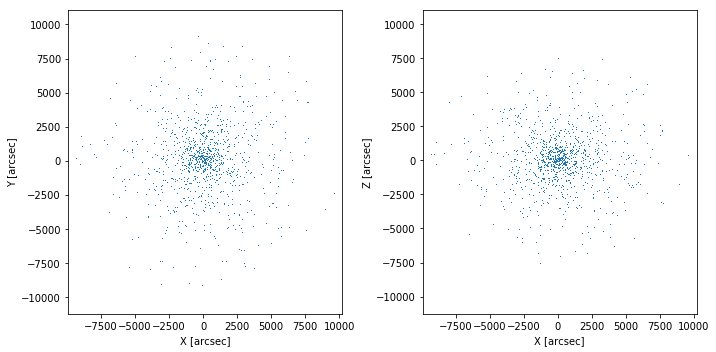

In [12]:
# Plotting Y versus X, and Z versus X, showing the slight flattening
fig = figure(1, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(myMGE.x, myMGE.y, ',')
ax1.set_aspect('equal', 'datalim')
ax1.set_xlabel("X [arcsec]")
ax1.set_ylabel("Y [arcsec]")
ax2 = fig.add_subplot(122)
ax2.plot(myMGE.x, myMGE.z, ',')
ax2.set_aspect('equal', 'datalim')
ax2.set_xlabel("X [arcsec]")
ax2.set_ylabel("Z [arcsec]")
tight_layout()

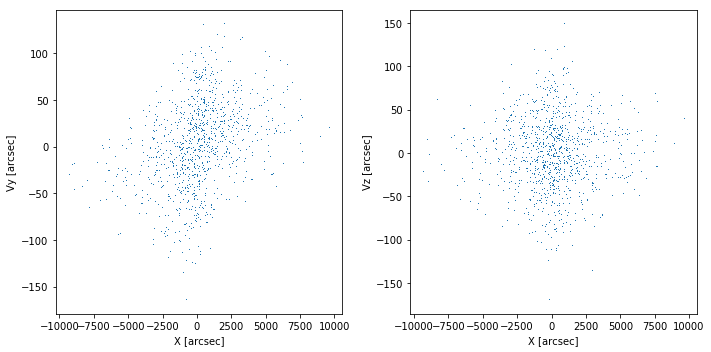

In [13]:
# Plotting Vx versus X, and Vy versus X, showing the slight flattening
fig = figure(1, figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(myMGE.x, myMGE.Vy, ',')
ax1.set_xlabel("X [arcsec]")
ax1.set_ylabel("Vy [arcsec]")
ax2 = fig.add_subplot(122)
ax2.plot(myMGE.x, myMGE.Vz, ',')
ax2.set_xlabel("X [arcsec]")
ax2.set_ylabel("Vz [arcsec]")
tight_layout()

### And we can convert it into a Gadget file

In [14]:
# Convert into a Gadget file so we don't have to recompute things several times for this particular setup
from pygme import convert_snapshot
convert_snapshot.mge_to_gadget(myMGE, filename="Sersic_model001_q08.dat")

----------------------------
Units in SIMULATION (Standard):
 Mass (solar masses)= 1.0
 Distance (kiloparcsec)= 1.0
 Velocity (km/s)= 1.0
 Constant of Gravitation (Msol/pc/yr)= 4.5e-15
 Density= 1e-09
 Time (years)= 471404520791.0317
 Specific Internal Energy= 4.5e-18
 Volume Internal Energy= 4.5e-27
----------------------------
----------------------------
Units in SIMULATION (GADGET2):
 Mass (solar masses)= 10000000000.0
 Distance (kiloparcsec)= 1.0
 Velocity (km/s)= 1.0
 Constant of Gravitation (Msol/pc/yr)= 4.5e-15
 Density= 10.0
 Time (years)= 4714045.207910317
 Specific Internal Energy= 4.5e-08
 Volume Internal Energy= 4.5e-07
----------------------------
Writing the Gadget file : Sersic_model001_q08.dat


### You can also use the model to compute LOSVDs

In [15]:
## Import the histogram functionalities
from pygme.pyhist import comp_losvd
## Number of points in the Velocity direction
nv = 101
maxV = 1000.0 ## in km/s, maximum velocity for the LOSVDs
## Number of point in the X and Y direction (the total number will be nXY * nXY)
## You can also specify a tupple for different numbers in X and Y
nXY = 101 
scaleR = 5000.0 # in parsec
## Compute the LOSVDs
los =  comp_losvd(myMGE.x, myMGE.z, myMGE.Vz, weights=myMGE.BodMass, \
                  limXY=[-scaleR, scaleR, -scaleR, scaleR], nXY=nXY, limV=[-maxV,maxV], nV=nv)

Text(0,0.5,'LOSVD')

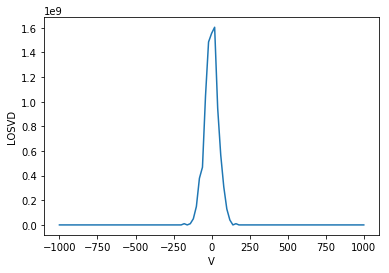

In [16]:
print(los)
## PLotting some LOSVD. Here the sum of all computed LOSVDs
rlos = np.linspace(-maxV, maxV, nv)
sumLOSVD = los.losvd.sum(axis=(0,1))
plot(rlos, sumLOSVD)
xlabel("V")
ylabel("LOSVD")

In [17]:
# You can also fit a Gauss-Hermite function on this one
from pygme.fitting import fitGaussHermite
bestR, result, GHbest = fitGaussHermite.fitGH_mpfit(rlos, sumLOSVD, degGH=4)

------ Starting the minimisation -------
Chi2 =  9.322678880412968e+16
Chi2 =  5.703444643455935e+16
Chi2 =  5.697263521999823e+16
Chi2 =  5.697263189939335e+16
=====
FIT: 
        I         V         Sig   
   1657511643.438     0.245     41.255 
GH 03:  -0.0117 
GH 04:   0.0359 
Chi2:  5.697263189796754e+16  Reduced Chi2:  564085464336312.2


/home/emsellem/anaconda3/lib/python3.6/site-packages/pygme/fitting/mpfit.py:2268: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


[ 1.65751164e+09  2.45398326e-01  4.12548087e+01 -1.16813953e-02
  3.59491571e-02]


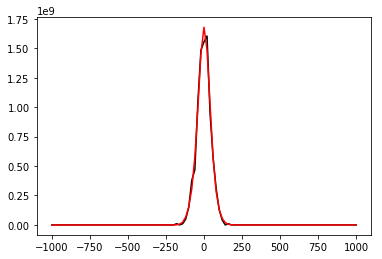

In [18]:
print(bestR)
plot(rlos, sumLOSVD, 'k-')
plot(rlos, GHbest, 'r-')

/home/emsellem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


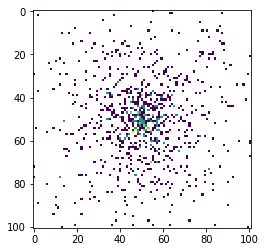

In [20]:
# Of course too few particles...
imshow(np.log10(los.losvd.sum(axis=2)))